In [1]:
#-- IMPORTING MODULES --
import numpy as np
import mpmath as mp

import math
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import fsolve
import scipy.misc
from scipy.misc import derivative
import scipy.interpolate
from scipy.interpolate import griddata
from scipy.integrate import quad, trapz, cumtrapz, romberg, fixed_quad, odeint, ode
from scipy import linalg
from numpy.linalg import inv
from scipy.special import gamma, hyp1f1
from scipy.interpolate import interp1d
import time
from astropy.table import Table, Column, MaskedColumn

#Atropy cosmology modules
import astropy.units as astrou
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
from astropy.cosmology import z_at_value
from astropy.io import fits

# Import mycode
import sys
path = '/Users/feixu/OneDrive - The University of Chicago/Documents/Research'
sys.path.append(path+'/mycode/')
sys.path.append(path+'/lensingFei/')
import constantfei 
from detector_snr_fei import *
from optical_depthfei import *
from gw import *
from RBBH_fei import *


#Plotting
from matplotlib.ticker import ScalarFormatter
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

#Export results folder
import sys
dir_base=sys.path[0]
dir_out1=dir_base+"/plots_py_gw_lensing/"
dir_out2=dir_base+"/fits_py_gw_lensing/"

         	Approximation will be used...
4.551812916295461


/Users/feixu/OneDrive - The University of Chicago/Documents/Research/GW_len/github/RBBH_fei.py:73: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  normmchirp = integrate.quad(lambda x: mchirpspl(x), Mchirpmin, Mchirpmax)[0]
/Users/feixu/OneDrive - The University of Chicago/Documents/Research/GW_len/github/RBBH_fei.py:84: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determin

In [2]:
def dR_dz_fun(z, sigma_star, Detector, params):
    #print(params)
    
    zp = params[0][0]
    alpha = params[0][1]
    beta = params[0][2]

    
    def R_2powerlaw(z, zp, alpha, beta):
        #print(zp, alpha, beta)
        return (1+(1+zp)**(-alpha-beta))*((1+z)**alpha)/(1+((1+z)/(1+zp))**(alpha+beta))
    R_2powerlawv = np.vectorize(R_2powerlaw)
    
    ezpowerlaw = interpolate.interp1d(np.linspace(0, 10, num=100), \
                                      R_2powerlawv(np.linspace(0, 10, num=100), zp, alpha, beta), kind='linear', fill_value='extrapolate')
    
    def dR_dz_org_temp(z):
        r_c = cosmo.comoving_distance(z).value*constantfei.Mpc_m
        return r0*ezpowerlaw(z)/(1+z)*(4*np.pi*c*r_c*r_c/(cosmo.H(z).value*1e3/constantfei.Mpc_m))

    dR_dz_org_tempv = np.vectorize(dR_dz_org_temp)
 
    #These are in detector frame
    if (Detector == 'aLIGO'):
        dR_obs_dz = fractfun_aligo(z)*dR_dz_org_tempv(z)*(3600*365*24)
        
    if (Detector == 'A+'):
        dR_obs_dz = fractfun_aplus(z)*dR_dz_org_tempv(z)*(3600*365*24)
        
    if (Detector == 'ET'):
        dR_obs_dz = fractfun_ET(z)*dR_dz_org_tempv(z)*(3600*365*24)
        
    if (Detector == 'CE'):
        dR_obs_dz = fractfun_CE(z)*dR_dz_org_tempv(z)*(3600*365*24)
        
    
    return dR_obs_dz*tau_spec(z, sigma_star) # SI unit per year

dR_dz_funv = np.vectorize(dR_dz_fun)




In [3]:
zpeakl = np.linspace(0, 5, num=20)
betal = np.linspace(0, 15, num=40)

In [4]:
Rcum_lensing_aplus_arr = np.zeros((len(zpeakl), len(betal)))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


54.37129211425781


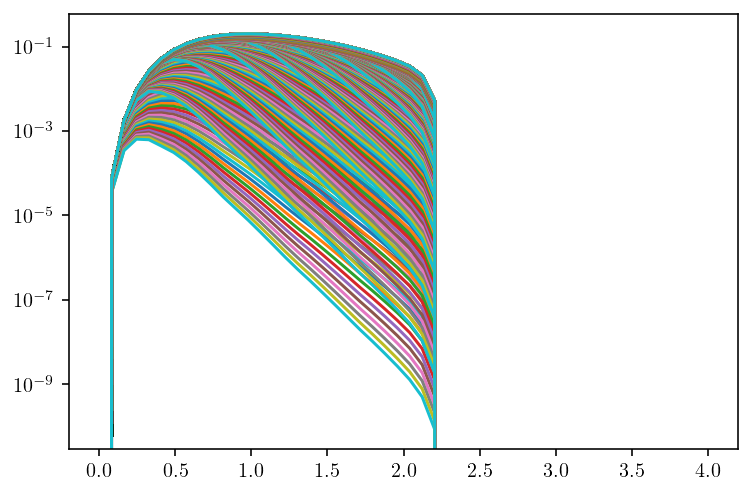

In [5]:
alpha = 1

dR_dz_allsave = []

start0 = time.time()
for i, zp in enumerate(zpeakl):
    for j, beta in enumerate(betal):
        start = time.time()
        dR_dz_all = []
        
        zl = np.linspace(0, 4, num=50)
        
        dR_dz_all.append(dR_dz_fun(zl, 161e3, 'A+', [[zp, alpha, beta]]))
        
        plt.plot(zl, dR_dz_all[-1])
        plt.yscale('log')
        
        spl = interpolate.interp1d(zl, dR_dz_all[-1], kind='linear')
            
        Rcum_lensing_aplus_arr[i, j] = integrate.quad(lambda x: spl(x), 0, 4)[0]

end0 = time.time()

print(end0-start0)


In [6]:
BETA, ZPEAK = np.meshgrid(betal, zpeakl)
BETA_denser, ZPEAK_denser = \
np.meshgrid(np.linspace(betal[0], betal[-1], num=800), np.linspace(zpeakl[0], zpeakl[-1], num=800))


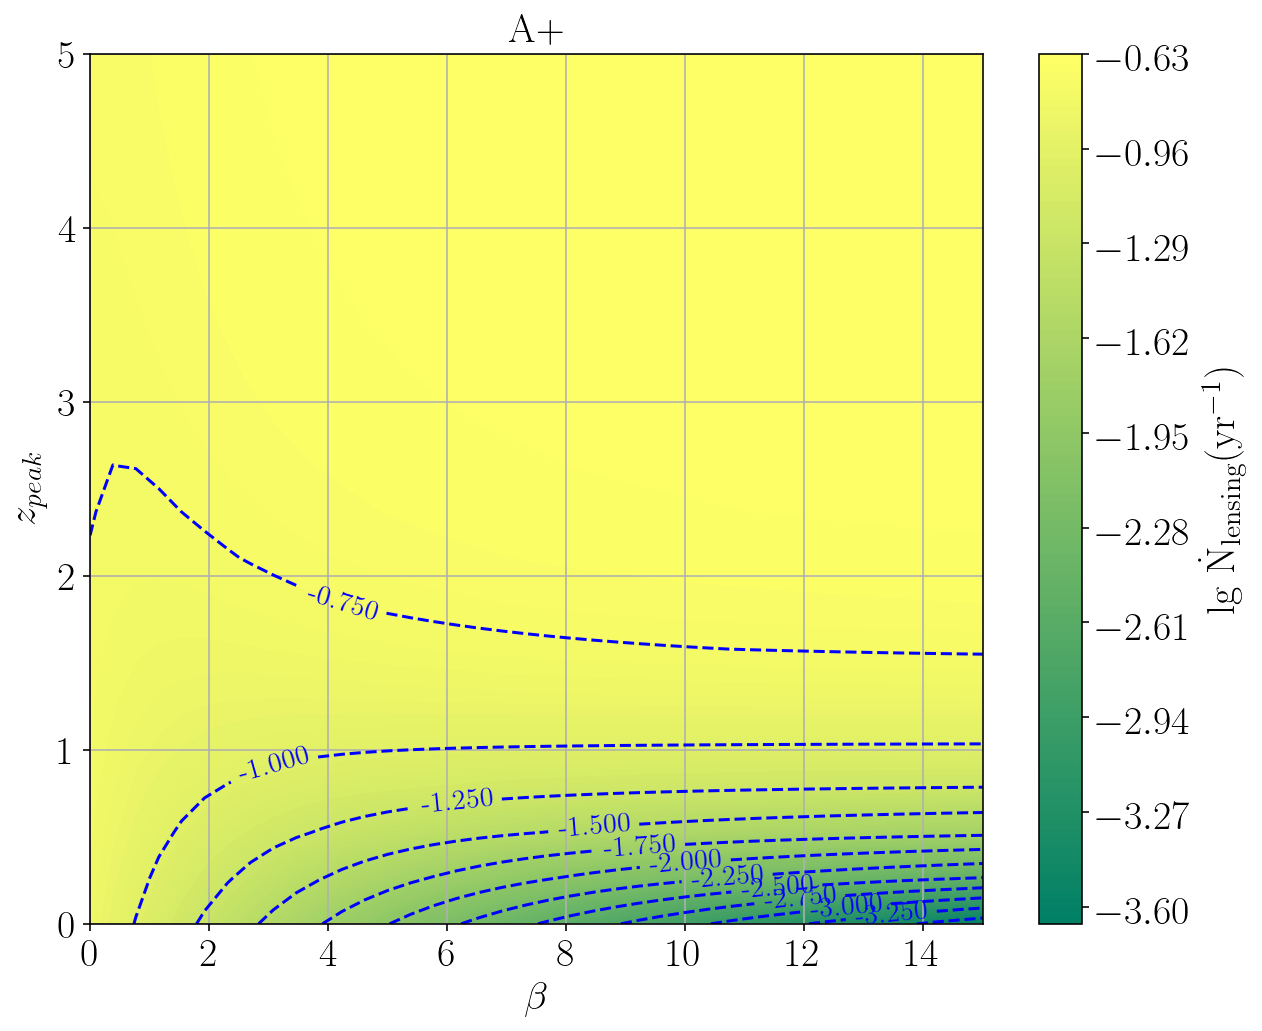

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
CS = plt.contourf(BETA, ZPEAK, np.log10(Rcum_lensing_aplus_arr), levels=100, cmap="summer")

cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)
cb.set_label(label=r"$\rm lg\ \dot{N}_{lensing} (yr^{-1})$", size=20)

CS = plt.contour(BETA, ZPEAK, np.log10(Rcum_lensing_aplus_arr), \
                 levels=12, colors='blue')
ax.clabel(CS, inline=1, fontsize=14)

#p1C = CS.collections[1].get_paths()[0]
#coor_p1C = p1C.vertices
#BETAC = coor_p1C[:,0]
#ZPEAKC = coor_p1C[:,1]
#splC = interpolate.interp1d(BETAC, ZPEAKC, kind='linear', fill_value = 'extrapolate')






#plt.plot(BETAC, ZPEAKC, '-', color='black', linewidth=3)
#plt.plot(BETAC, splC(BETAC), '-')
#ax.clabel(CS, inline=1, fontsize=13)

#ind_nondetection = np.where(ZPEAK_denser < splC(BETA_denser))
#plt.plot(BETA_denser[ind_nondetection], ZPEAK_denser[ind_nondetection], 'x', alpha=0.01)


plt.xlabel(r'$\beta$', fontsize=20)
plt.ylabel('$z_{peak}$', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True)
plt.xlim(0,)
#plt.xscale('log')

plt.title('A+', fontsize=20)

plt.savefig(dir_out1+'R_lensing_contour_aplus_z_beta_withshadow.pdf')

Text(0, 0.5, 'dR/dz')

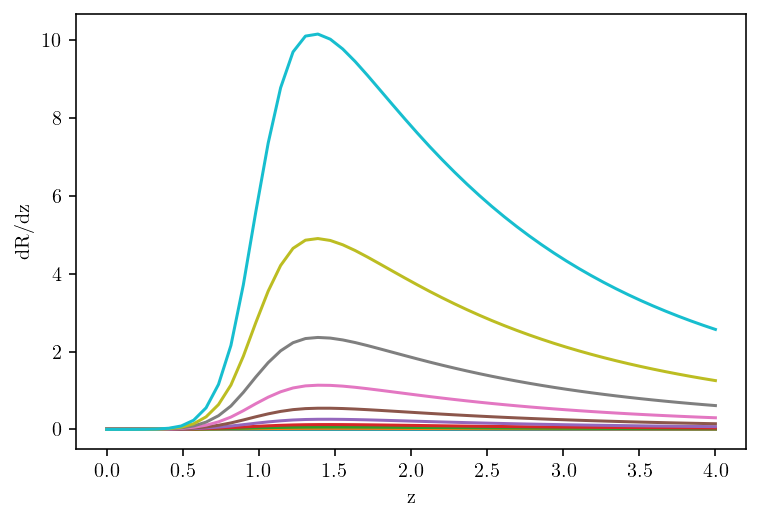

In [8]:
zpeakl = np.linspace(0, 5, num=20)
alphal = np.linspace(-15, 15, num=30)


for alpha0 in alphal:

    zp = 1
    alpha = alpha0
    beta = 1
        
    def R_2powerlaw_temp(z, zp, alpha, beta):
        #print(zp, alpha, beta)
        return (1+(1+zp)**(-alpha-beta))*((1+z)**alpha)/(1+((1+z)/(1+zp))**(alpha+beta))
    R_2powerlaw_tempv = np.vectorize(R_2powerlaw_temp)
    
    ezpowerlaw = interpolate.interp1d(np.linspace(0, 10, num=100), \
                                  R_2powerlaw_tempv(np.linspace(0, 10, num=100), zp, alpha, beta), kind='linear', fill_value='extrapolate')
    
    def dR_dz_org_temp(z):
        r_c = cosmo.comoving_distance(z).value*constantfei.Mpc_m
        return r0*ezpowerlaw(z)/(1+z)*(4*np.pi*c*r_c*r_c/(cosmo.H(z).value*1e3/constantfei.Mpc_m))

    dR_dz_org_tempv = np.vectorize(dR_dz_org_temp)
    
    zl = np.linspace(0, 4, num=50)
    
    plt.plot(zl, dR_dz_org_temp(zl), label=r'$\alpha$ = '+str(alpha))
    
plt.xlabel('z')
plt.ylabel('dR/dz')
#plt.legend(fontsize=20)
    

Text(0, 0.5, 'dR/dz')

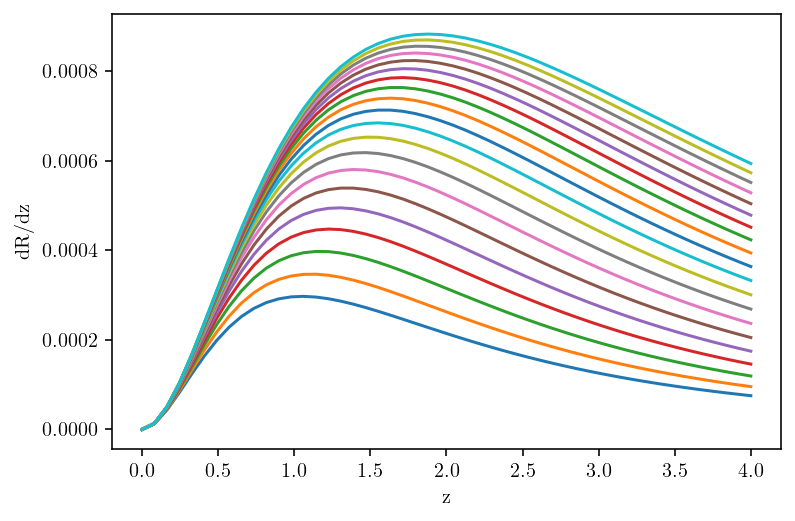

In [9]:
zpeakl = np.linspace(0, 5, num=20)
alphal = np.linspace(-15, 15, num=30)


for zpeak0 in zpeakl:

    zp = zpeak0
    alpha = 1
    beta = 1
        
    def R_2powerlaw_temp(z, zp, alpha, beta):
        #print(zp, alpha, beta)
        return (1+(1+zp)**(-alpha-beta))*((1+z)**alpha)/(1+((1+z)/(1+zp))**(alpha+beta))
    R_2powerlaw_tempv = np.vectorize(R_2powerlaw_temp)
    
    ezpowerlaw = interpolate.interp1d(np.linspace(0, 10, num=100), \
                                  R_2powerlaw_tempv(np.linspace(0, 10, num=100), zp, alpha, beta), kind='linear', fill_value='extrapolate')
    
    def dR_dz_org_temp(z):
        r_c = cosmo.comoving_distance(z).value*constantfei.Mpc_m
        return r0*ezpowerlaw(z)/(1+z)*(4*np.pi*c*r_c*r_c/(cosmo.H(z).value*1e3/constantfei.Mpc_m))

    dR_dz_org_tempv = np.vectorize(dR_dz_org_temp)
    
    zl = np.linspace(0, 4, num=50)
    
    plt.plot(zl, dR_dz_org_temp(zl), label=r'$\alpha$ = '+str(alpha))
    
plt.xlabel('z')
plt.ylabel('dR/dz')
#plt.legend(fontsize=20)
    